<div class="table-of-contents" style="background-color:#C2C4E2; color:black; padding: 20px; margin: 10px; font-size: 110%; border-radius: 25px; box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);">
  <h1>Contents</h1>
  <ol>
    <li><a href="#overview" style="color: blue;">1. Overview</a></li>
    <li><a href="#imports" style="color: blue;">2. Imports</a></li>
    <li><a href="#data-preprocessing" style="color: blue;">3. Data Preprocessing</a></li>
    <li><a href="#model" style="color: blue;">4. Model</a></li>
    <li><a href="#evaluation" style="color: blue;">5. Evaluation</a></li>
    <li><a href="#thank-you" style="color: blue;">6. Thank You</a></li>
  </ol>
</div>


<a id="overview"></a>
<h1 style='background:#C2C4E2;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center>Overview</center></h1>


**In this notebook, we will delve into the methodology of utilizing Tensorflow to train a model for object localization, providing a comprehensive overview of the steps and techniques involved in the process.**

<a id="imports"></a>
<h1 style='background:#C2C4E2;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center>Imports</center></h1>


# Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as xt
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px

from PIL import Image
from skimage import io
from glob import glob
from tensorflow.keras.models import Model
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten

<a id="data-preprocessing"></a>
<h1 style='background:#C2C4E2;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center>Data Preprocessing</center></h1>


# Data Preprocessing

**Let's view an xml file using beautifulsoup**

In [2]:
xml_example = '/kaggle/input/image-localization-dataset/training_images/mushroom_59.xml'

In [3]:
with open(xml_example, 'r') as f:
    data = f.read()
    content = BeautifulSoup(data, 'xml')
content

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>single mushroom</folder>
<filename>mushroom_59.jpg</filename>
<path>C:\Users\Muhammed Buyukkinaci\Downloads\single mushroom\mushroom_59.jpg</path>
<source>
<database>Unknown</database>
</source>
<size>
<width>227</width>
<height>227</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>mushroom</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>93</xmin>
<ymin>69</ymin>
<xmax>177</xmax>
<ymax>203</ymax>
</bndbox>
</object>
</annotation>

**Now that we have an idea of the xml content let's parse it and get the targets**

## Parsing XML and getting the Labels

In [4]:

path = sorted(glob('/kaggle/input/image-localization-dataset/training_images/*.xml'))# get all elements in path with xml extension
y = [] #create a list to store our targets
for file in path:# loop over each file path and parse it
    label = 0
    info = xt.parse(file) 
    root = info.getroot() 
    obj = root.find('object')
    
    label_obj = (obj.find('name').text)
    if "cucumber" in label_obj:  
        label = 1
    elif "eggplant" in label_obj:
        label = 2
    elif "mushroom" in label_obj:
        label = 3

    bndbox = obj.find('bndbox')
    xmin = (bndbox.find('xmin').text)
    xmax = (bndbox.find('xmax').text)
    ymin = (bndbox.find('ymin').text)
    ymax = (bndbox.find('ymax').text)
    
    #append the results to our target
    y.append([int(label),int(xmin),int(ymin),int(xmax),int(ymax)])



## Reading Images

In [5]:
X = []
images_path = sorted(glob('/kaggle/input/image-localization-dataset/training_images/*.jpg'))# get all elements in path with jpg extension

for image in images_path:#loop over image path
    img = cv2.imread(image, cv2.COLOR_BGR2RGB)# read the image in rgb mode
    X.append(img)

## Checking if we got the correct data

In [6]:
img_example = X[0]
bbox = y[0][1:]
y[1][1:] #view the bbox coordinates

[13, 70, 219, 160]


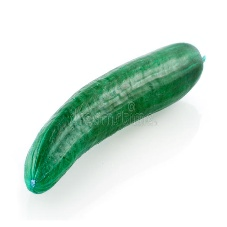

In [7]:

fig = px.imshow(img_example)
fig.update_layout(width=800, height=600, margin=dict(l=10, r=10, b=10, t=10))
fig.add_shape(type='rect',x0=bbox[0], x1=bbox[2], y0=bbox[1], y1=bbox[3], xref='x', yref='y',line_color='cyan')

**Now let's set our X and y values**

In [8]:
X = np.array(X)
y =  np.array(y)

**Split data**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

**We are trying to predict the bbox coordinates and the category so let's split the labels**

In [10]:
categ_train = y_train[:,0:1]
categ_test = y_test[:,0:1]
bbox_train = y_train[:,1:]
bbox_test = y_test[:,1:]
categ_train.shape,categ_test.shape,bbox_train.shape,bbox_test.shape

((148, 1), (38, 1), (148, 4), (38, 4))

In [11]:
categ_train = tf.keras.utils.to_categorical(categ_train)
categ_test = tf.keras.utils.to_categorical(categ_test)

**Now that our data is ready let's train our model**

<a id="model"></a>
<h1 style='background:#C2C4E2;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center>Model</center></h1>


# Model
**We will use InceptionV3 network for transfer learning**

In [12]:
#Load InceptionV3
inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(227,227,3))

2023-01-15 15:00:38.333230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 15:00:38.337020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 15:00:38.337745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 15:00:38.339392: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step


In [13]:
inception.trainable = True #Set layers to trainable

last_layer = inception.get_layer('mixed10') #get last layer in inception

print('last layer output shape: ', last_layer.output_shape)

layer_output = last_layer.output

last layer output shape:  (None, 5, 5, 2048)


## Define Dense model architecture

In [14]:
x = Flatten()(layer_output)
x1 = Dropout(0.3)(x)
x2 = Dense(4112,activation="relu")(x1)
drop1 = Dropout(0.3)(x2)
x3 = Dense(1028,activation="relu")(x2)
x4 = Dense(1028,activation="relu")(x3)
drop1 = Dropout(0.5)(x4)

x5 = Dense(256,activation="relu")(drop1)
drop2 = Dropout(0.3)(x5)
classification_output = Dense(4,activation='softmax',name = 'classification')(x2)
bounding_box_output = Dense(4,name = 'bounding_box')(x5)
model = tf.keras.Model(inputs = inception.inputs, outputs = [classification_output, bounding_box_output])

In [15]:
def scheduler(epoch, lr):
    """
    Applies exponential decay
    Args:
    epoch: Epoch to start the decay at
    lr: current learning rate
    """
    if epoch < 40:
        return lr
    else:
        return lr * tf.math.exp(-0.12)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [16]:
  model.compile(optimizer=Adam(learning_rate=1e-4),
              loss = {'classification' : 'categorical_crossentropy',
                      'bounding_box' : 'mse'
                     },
              metrics = {'classification' : 'accuracy',
                         'bounding_box' : 'mse'
                        })

In [17]:
r= model.fit(X_train,[categ_train,bbox_train],epochs=70,validation_data=(X_test,[categ_test,bbox_test]),callbacks=[callback])

2023-01-15 15:00:43.838925: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2023-01-15 15:00:51.937610: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5/5 [==============================] - 18s 803ms/step - loss: 16184.1064 - classification_loss: 1.9905 - bounding_box_loss: 16182.1152 - classification_accuracy: 0.2703 - bounding_box_mse: 16182.1152 - val_loss: 3737.8064 - val_classification_loss: 2.8565 - val_bounding_box_loss: 3734.9500 - val_classification_accuracy: 0.3421 - val_bounding_box_mse: 3734.9500
Epoch 2/70
5/5 [==============================] - 1s 177ms/step - loss: 3823.8572 - classification_loss: 1.5152 - bounding_box_loss: 3822.3420 - classification_accuracy: 0.3716 - bounding_box_mse: 3822.3420 - val_loss: 21721.6055 - val_classification_loss: 1.5415 - val_bounding_box_loss: 21720.0645 - val_classification_accuracy: 0.3158 - val_bounding_box_mse: 21720.0645
Epoch 3/70
5/5 [==============================] - 1s 176ms/step - loss: 3298.8132 - classification_loss: 1.3924 - bounding_box_loss: 3297.4211 - classification_accuracy: 0.3784 - bounding_box_mse: 3297.4211 - val_loss: 4738.4932 - val_classification_loss: 2.2854 -

**The model is clearly overfitting but let's evaluate the results**

In [18]:
results = pd.DataFrame(r.history)
results.tail()

,loss,classification_loss,bounding_box_loss,classification_accuracy,bounding_box_mse,val_loss,val_classification_loss,val_bounding_box_loss,val_classification_accuracy,val_bounding_box_mse,lr
65,170.417633,0.070686,170.346939,0.993243,170.346939,327.834351,0.162505,327.671844,0.973684,327.671844,0.000004
66,150.685593,0.060970,150.624634,1.000000,150.624634,325.079712,0.160449,324.919250,0.973684,324.919250,0.000004
67,169.587845,0.061709,169.526154,1.000000,169.526154,323.010437,0.158808,322.851654,0.973684,322.851654,0.000003
68,162.256470,0.069413,162.187057,1.000000,162.187057,321.172760,0.157707,321.015045,0.973684,321.015045,0.000003
69,187.451813,0.060588,187.391235,1.000000,187.391235,319.757111,0.156768,319.600342,0.973684,319.600342,0.000003


In [19]:
fig = px.line(results,y=[results['classification_loss'],results['val_classification_loss']],template="seaborn",color_discrete_sequence=['#05445E','#75E6DA'])
fig.update_layout(   
    title_font_color="#75E6DA", 
    xaxis=dict(color="#75E6DA",title='Epochs'), 
    yaxis=dict(color="#75E6DA")
 )
fig.show()

In [20]:

fig = px.line(results,y=[results['classification_accuracy'],results['val_classification_accuracy']],template="seaborn",color_discrete_sequence=['#05445E','#75E6DA'])
fig.update_layout(   
    title_font_color="#75E6DA", 
    xaxis=dict(color="#75E6DA",title='Epochs'), 
    yaxis=dict(color="#75E6DA")
 )
fig.show()

In [21]:
fig = px.line(results,y=[results['bounding_box_loss'],results['val_bounding_box_loss']],template="seaborn",color_discrete_sequence=['#05445E','#75E6DA'])
fig.update_layout(   
    title_font_color="#75E6DA", 
    xaxis=dict(color="#75E6DA",title='Epochs'), 
    yaxis=dict(color="#75E6DA")
 )
fig.show()

<a id="evaluation"></a>
<h1 style='background:#C2C4E2;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center>Evaluation</center></h1>


# Evaluation

**Now let's make some predictions**


**Define a function to help us predict**

In [22]:
def predict(path, model, from_url=False):
    """
    passes an image to a trained model and returns annotated image

    Args:
    path:  path containing the image or a list of paths
    model:  pretrained model instance
    from_url: (boolen) to check if the path is a url
    """
    # Check if the path is a list
    if type(path) == list:
        # loop over each path and read the image
        for p in path:
            if from_url:
                image = io.imread(p)
            else:
                image = cv2.imread(p)
    # Check if the type of the path is a string
    elif type(path) == str:
            # read the given image
            if from_url:
                image = io.imread(path)
            else:
                image = cv2.imread(path)
    # Resize the image into the appropriate shape    
    image = cv2.resize(image,(227,227))
    # get model predictions
    categ,bbox = model.predict(np.array([image]))
    # Get class of the highest given probability
    categ = np.argmax(categ)
    # flatten the bounding box array and cast it into integer
    bbox = bbox.flatten()
    bbox = bbox.astype(int)
    # draw a rectangle on the image using the predicted bbox coordinates
    image = cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(255,0,0),1)
    # set prediction class to an empty string
    prediction = ''
    # set the prediction to the name of the given class according to the model's prediction
    if categ == 1:
        prediction = 'Cucumber'
    elif categ == 2:
        prediction = 'Egg Plant'
    elif categ == 3:
        prediction = 'Mushroom'
    # Put the text of the prediction on the image
    final_img = cv2.putText(image,prediction,(bbox[0],bbox[1]-4),cv2.FONT_HERSHEY_SIMPLEX,0.3,(255,0,0),1,255)
    # Plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(final_img)
    plt.axis('off')
    plt.show()

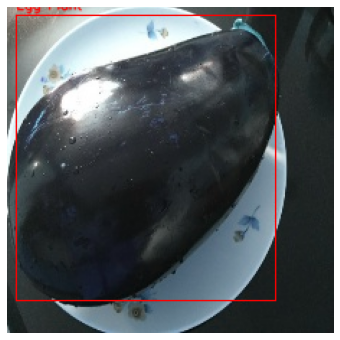

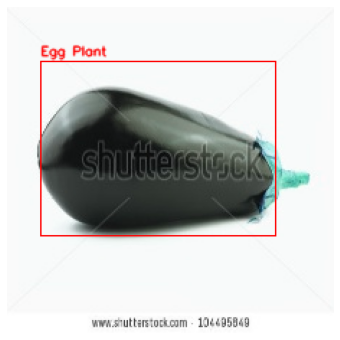

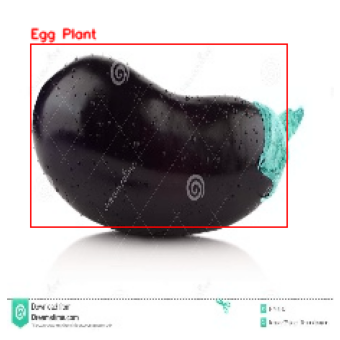

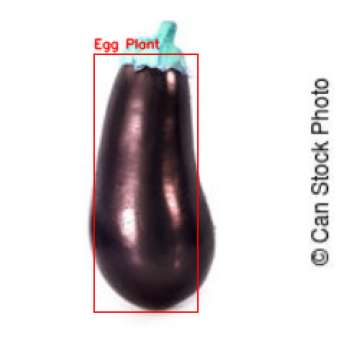

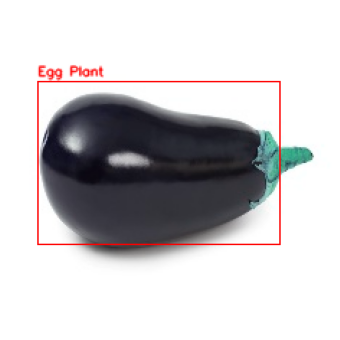

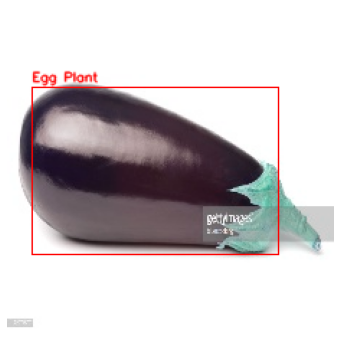

In [23]:
for i in range(40,46):
    paths = []
    paths.append(f'/kaggle/input/image-localization-dataset/training_images/eggplant_{i}.jpg')
    predict(paths,model,False)

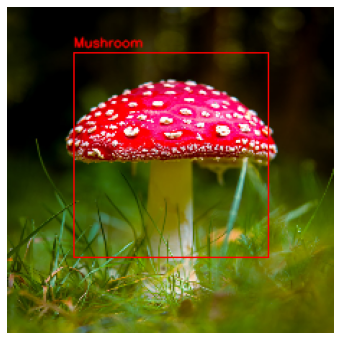

In [24]:
predict('https://images.unsplash.com/photo-1630921121767-81e86d066a5d?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MTd8fG11c2hyb29tfGVufDB8fDB8fA%3D%3D&w=1000&q=80',model,True)

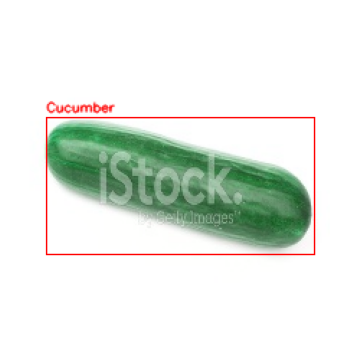

In [25]:
predict('/kaggle/input/image-localization-dataset/training_images/cucumber_37.jpg',model)

<a id="thank-you"></a>
<h1 style='background:#C2C4E2;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center>Thank You</center></h1>


# Thank You

**Thank you for going through this notebook I appreciate your time**

**If you have any feedback please let me know**